In [1]:
import torch
from tqdm import tqdm
import numpy as np
import cv2
import albumentations as A
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from diffusers import StableDiffusionImageVariationPipeline, DDPMScheduler
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from accelerate import Accelerator
import matplotlib.pyplot as plt
import logging
import torch.nn.functional as F
import torch.amp
from collections import defaultdict
import random
from PIL import Image

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
class ImageGuidedPatternGenerator:
    def __init__(
        self,
        model_name: str = "lambdalabs/sd-image-variations-diffusers",
        device: str = "cuda",
        clip_model_name: str = "openai/clip-vit-base-patch32"
    ):
        self.device = device if torch.cuda.is_available() else "cpu"
        self.model_name = model_name
        self.clip_model_name = clip_model_name
        
        # Load CLIP components
        self.clip_processor = CLIPImageProcessor.from_pretrained(clip_model_name)
        self.clip_encoder = CLIPVisionModelWithProjection.from_pretrained(clip_model_name).to(self.device)
        
        # Add projection layer to match UNet's expected dimensions
        self.projection = torch.nn.Linear(
            self.clip_encoder.config.projection_dim,  # 512 for base CLIP
            768  # SD UNet's expected hidden size
        ).to(self.device)
        
        # Load SD pipeline
        self.pipe = StableDiffusionImageVariationPipeline.from_pretrained(
            model_name,
            clip_vision_model=self.clip_encoder,
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32
        ).to(self.device)
        
        # Freeze CLIP encoder
        self.clip_encoder.requires_grad_(False)
        
        logger.info(f"Loaded {model_name} successfully on {self.device}")

    def _resize_image(self, image: Image.Image, target_size: tuple) -> Image.Image:
        """Resize image while maintaining aspect ratio and padding to target size."""
        width, height = image.size
        aspect_ratio = width / height
        
        if width > height:
            new_width = target_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = target_size[1]
            new_width = int(new_height * aspect_ratio)
        
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)
        
        # Pad to target size
        padded_image = Image.new("RGB", target_size, (0, 0, 0))
        padded_image.paste(resized_image, ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2))
        
        return padded_image

    def generate_variations(
        self,
        input_image: Image.Image,
        num_variations: int = 5,
        strength: float = 0.7,
        guidance_scale: float = 8.0,
        num_inference_steps: int = 50,
        seed: int = None
    ) -> list:
        """Generate variations for an input image."""
        input_image = input_image.convert("RGB")
        target_size = (512, 512)  # Default SD resolution
        input_image = self._resize_image(input_image, target_size)
        
        generated_images = []
        for idx in range(num_variations):
            generator = torch.Generator(device=self.device)
            if seed:
                generator.manual_seed(seed + idx)
            
            result = self.pipe(
                image=input_image,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                generator=generator,
                height=target_size[1],
                width=target_size[0]
            )
            generated_images.append(result.images[0])
        
        return generated_images

In [4]:
class NestedPatternDataset(Dataset):
    def __init__(self, root_dir, target_size=(512, 512), subset_fraction=0.5, seed=42):
        self.root_dir = Path(root_dir)
        self.target_size = target_size
        self.seed = seed

        # Set random seed for reproducibility
        random.seed(self.seed)
        np.random.seed(self.seed)

        # Find all image groups
        self.image_groups = self._find_image_groups()

        # Create all possible pairs
        self.all_pairs = self._create_pairs()

        # Get subset of pairs first
        self.pairs = self._get_subset_pairs(subset_fraction)  # <--- THIS WAS MISSING

        # Validate pairs after subset selection
        self.pairs = self._validate_pairs(self.pairs)  # <--- VALIDATE AFTER SUBSET

        self.transform = A.Compose([
            A.LongestMaxSize(max(target_size)),
            A.PadIfNeeded(
                min_height=target_size[0],
                min_width=target_size[1],
                border_mode=cv2.BORDER_CONSTANT,
                value=(0, 0, 0)
            ),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.variation_aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.2)
        ])

    def _validate_pairs(self, pairs):
        """Remove pairs with missing or corrupt images."""
        valid_pairs = []
        for pair in tqdm(pairs, desc="Validating pairs"):
            input_path, variation_path = pair
            if not input_path.exists() or not variation_path.exists():
                continue
            # Try loading images to check for corruption
            try:
                self._load_image(input_path)
                self._load_image(variation_path)
                valid_pairs.append(pair)
            except:
                continue
        return valid_pairs

    def _find_image_groups(self):
        image_paths = list(self.root_dir.rglob('*.[jp][pn]g'))
        groups = defaultdict(list)
        for path in image_paths:
            groups[path.parent].append(path)
        return groups

    def _create_pairs(self):
        pairs = []
        for parent, paths in self.image_groups.items():
            input_images = [p for p in paths if p.stem == '0']
            variations = [p for p in paths if p.stem != '0']
            if input_images and variations:
                main_input = sorted(input_images, key=lambda x: x.suffix)[0]
                for var in variations:
                    pairs.append((main_input, var))
        return pairs

    def _get_subset_pairs(self, subset_fraction):
        """
        Randomly select a subset of pairs based on the given fraction.
        
        Args:
            subset_fraction (float): Fraction of pairs to keep (0.0 to 1.0)
        
        Returns:
            list: Subset of pairs
        """
        num_pairs = len(self.all_pairs)
        subset_size = int(num_pairs * subset_fraction)
        
        # Shuffle and select subset
        subset_pairs = random.sample(self.all_pairs, subset_size)
        
        print(f"Total pairs: {num_pairs}")
        print(f"Subset pairs: {len(subset_pairs)} ({subset_fraction * 100}%)")
        
        return subset_pairs

    def __len__(self):
        return len(self.pairs)

    def _load_image(self, path):
        """Load image with error handling."""
        try:
            image = cv2.imread(str(path))
            if image is None:
                raise ValueError(f"Failed to read image: {path}")
            return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading {path}: {str(e)}")
            raise

    def _process_image(self, image, is_variation=False):
        transformed = self.transform(image=image)
        image = transformed["image"]
        if is_variation:
            augmented = self.variation_aug(image=image)
            image = augmented["image"]
        return torch.from_numpy(image).permute(2, 0, 1).float()

    def __getitem__(self, idx):
        try:
            input_path, variation_path = self.pairs[idx]
            input_img = self._load_image(input_path)
            variation_img = self._load_image(variation_path)

            input_tensor = self._process_image(input_img)
            variation_tensor = self._process_image(variation_img, is_variation=True)

            return {
                'input': input_tensor,
                'variation': variation_tensor,
                'input_path': str(input_path),
                'variation_path': str(variation_path)
            }
        except Exception as e:
            print(f"Skipping corrupted pair {self.pairs[idx]}: {str(e)}")
            return None

In [5]:
def collate_fn(batch):
    """Filter out None samples from dataset."""
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # Handle empty batches in training loop
    return torch.utils.data.default_collate(batch)

In [13]:

class FineTuner:
    def __init__(self, generator_model, train_config):
        self.model = generator_model
        self.config = train_config

        # Enable gradient checkpointing to reduce memory usage
        self.model.pipe.unet.enable_gradient_checkpointing()

        # Lower precision and more aggressive memory management
        self.accelerator = Accelerator(
            mixed_precision='fp16',
            gradient_accumulation_steps=train_config.get('gradient_accumulation_steps', 4)
        )

        # Smaller target size to reduce memory
        self.dataset = NestedPatternDataset(
            root_dir=self.config['dataset_path'],
            target_size=self.config.get('target_size', (256, 256)),
            subset_fraction=self.config.get('subset_fraction', 0.5),  # New parameter
            seed=self.config.get('seed', 42)  # Optional seed for reproducibility
        )

        self.dataloader = DataLoader(
            self.dataset,
            batch_size=self.config.get('batch_size', 1),
            shuffle=True,
            num_workers=self.config.get('num_workers', 0),  # Start with 0 for debugging
            pin_memory=True,
            persistent_workers=False,  # Disable for stability
            collate_fn=collate_fn
        )
        # Freeze unnecessary components
        self.model.pipe.vae.requires_grad_(False)
        # Removed text_encoder freezing for Image Variation Pipeline

        self.optimizer = torch.optim.AdamW(
            self.model.pipe.unet.parameters(),
            lr=self.config['learning_rate'],
            weight_decay=self.config.get('weight_decay', 1e-6)
        )

        # Prepare models with memory-efficient settings
        (
            self.model.pipe.unet,
            self.optimizer,
            self.dataloader
        ) = self.accelerator.prepare(
            self.model.pipe.unet,
            self.optimizer,
            self.dataloader
        )

        # More memory-efficient noise scheduler
        self.noise_scheduler = DDPMScheduler(
            num_train_timesteps=500,  # Reduced from 1000
            beta_start=0.0001,
            beta_end=0.02,
            beta_schedule="linear"
        )

        # Clear GPU memory initially
        torch.cuda.empty_cache()

    def train_epoch(self):
        self.model.pipe.unet.train()
        total_loss = 0.0
        self.optimizer.zero_grad()

        # Use tqdm for progress tracking
        progress_bar = tqdm(self.dataloader, desc="Training", unit="batch")

        for step, batch in enumerate(progress_bar):
            if batch is None:
                continue
            with self.accelerator.accumulate(self.model.pipe.unet):
                inputs = batch['input'].to(self.accelerator.device, dtype=torch.float16)
                variations = batch['variation'].to(self.accelerator.device, dtype=torch.float16)

                with torch.amp.autocast('cuda', dtype=torch.float16):
                    inputs_rescaled = (inputs + 1.0) / 2.0

                    with torch.no_grad():
                        clip_inputs = self.model.clip_processor.preprocess(
                            inputs_rescaled,
                            return_tensors="pt",
                            do_rescale=False
                        ).to(self.accelerator.device)

                        clip_output = self.model.clip_encoder(**clip_inputs)
                        embeddings = self.model.projection(clip_output.image_embeds)
                        embeddings = embeddings.unsqueeze(1)

                    latents = self.model.pipe.vae.encode(variations).latent_dist.sample()
                    latents = latents * self.model.pipe.vae.config.scaling_factor

                    noise = torch.randn_like(latents)
                    timesteps = torch.randint(
                        0,
                        self.noise_scheduler.config.num_train_timesteps,
                        (latents.shape[0],),
                        device=latents.device
                    ).long()

                    noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

                    model_pred = self.model.pipe.unet(
                        noisy_latents,
                        timesteps,
                        encoder_hidden_states=embeddings
                    ).sample

                    loss = F.mse_loss(model_pred, noise)

                self.accelerator.backward(loss)

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())
            
            # Memory cleanup
            del inputs, variations, latents, noise, noisy_latents, model_pred
            torch.cuda.empty_cache()

            total_loss += loss.detach().float()

        return total_loss / len(self.dataloader)

    def train(self, test_images, resume=False, start_epoch=0):
        start_epoch = start_epoch if resume else 0
        for epoch in range(start_epoch, self.config['num_epochs']):

            if (epoch + 1) % self.config.get('display_every', 5) == 0:
                self.generate_test_variations(test_images)
            
            avg_loss = self.train_epoch()
            print(f"Epoch {epoch+1}/{self.config['num_epochs']} - Loss: {avg_loss:.4f}")

            if (epoch + 1) % self.config['save_every'] == 0:
                self.save_checkpoint(epoch + 1)
                
            # Less frequent visualization to reduce memory pressure
           

    def generate_test_variations(self, test_images, num_variations=5):
        """Generate and display variations for test images."""
        self.model.pipe.unet.eval().half()  # Keep UNet in half-precision for memory
        self.model.pipe.vae.eval().float()  # Set VAE to float32 to prevent dtype mismatch
    
        # Load images from paths if they are strings
        if isinstance(test_images[0], str):
            test_images = [Image.open(img_path) for img_path in test_images]
    
        fig, axes = plt.subplots(len(test_images), num_variations + 1, figsize=(20, 5 * len(test_images)))
    
        if len(test_images) == 1:
            axes = axes[np.newaxis, :]
    
        with torch.no_grad():
            for img_idx, test_img in enumerate(test_images):
                test_img = test_img.convert("RGB")
                variations = self.model.generate_variations(
                    input_image=test_img,
                    num_variations=num_variations,
                    guidance_scale=7.0,
                    num_inference_steps=50,
                    seed=42
                )
    
                # Display original image
                ax = axes[img_idx, 0]
                ax.imshow(test_img)
                ax.set_title("Original")
                ax.axis('off')
    
                # Display variations
                for var_idx, var_img in enumerate(variations):
                    ax = axes[img_idx, var_idx + 1]
                    ax.imshow(var_img)
                    ax.set_title(f"Variation {var_idx + 1}")
                    ax.axis('off')
    
        plt.tight_layout()
        plt.show()


    def save_checkpoint(self, epoch):
        checkpoint_path = Path(self.config['output_dir']) / f"checkpoint_{epoch}"
        checkpoint_path.mkdir(parents=True, exist_ok=True)
        unwrapped_unet = self.accelerator.unwrap_model(self.model.pipe.unet)
        torch.save(unwrapped_unet.state_dict(), checkpoint_path / "unet.pth")
        print(f"Saved checkpoint to {checkpoint_path}")

In [14]:
generator = ImageGuidedPatternGenerator()

Keyword arguments {'clip_vision_model': CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Line

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/42bc0ee1726b141d49f519a6ea02ccfbf073db2e/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/42bc0ee1726b141d49f519a6ea02ccfbf073db2e/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/42bc0ee1726b141d49f519a6ea02ccfbf073db2e/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/42bc0ee1726b141d49f519a6ea02ccfbf073db2e/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [15]:
test_image_paths = [
        "/kaggle/input/carpets-test-data/45.jpg",
        "/kaggle/input/carpet-designs-all/images/Floral/45.jpg"
]
test_images = [Image.open(path) for path in test_image_paths]

In [16]:
train_config = {
    'dataset_path': '/kaggle/input/carpet-variations',
    'target_size': (256, 256),
    'batch_size': 1,
    'learning_rate': 1e-5,
    'num_epochs': 20,
    'save_every': 1,
    'display_every': 1,
    'gradient_accumulation_steps': 4,
    'mixed_precision': 'fp16',  # Must be 'fp16' or 'no'
    'output_dir': '/kaggle/working/trained_models',
    'subset_fraction': 0.5,  # Train on half the dataset
    'seed': 42  # Optional seed for reproducibility
}

In [17]:
finetuner = FineTuner(generator, train_config)

Total pairs: 27733
Subset pairs: 13866 (50.0%)


Validating pairs: 100%|██████████| 13866/13866 [02:09<00:00, 107.17it/s]


In [18]:
checkpoint_path = Path("/kaggle/working/trained_models/checkpoint_8")
checkpoint_state_dict = torch.load(checkpoint_path / "unet.pth")
finetuner.model.pipe.unet.load_state_dict(checkpoint_state_dict)

<ipython-input-18-b56e6d0e2d32>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_state_dict = torch.load(checkpoint_path / "unet.pth")


<All keys matched successfully>

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

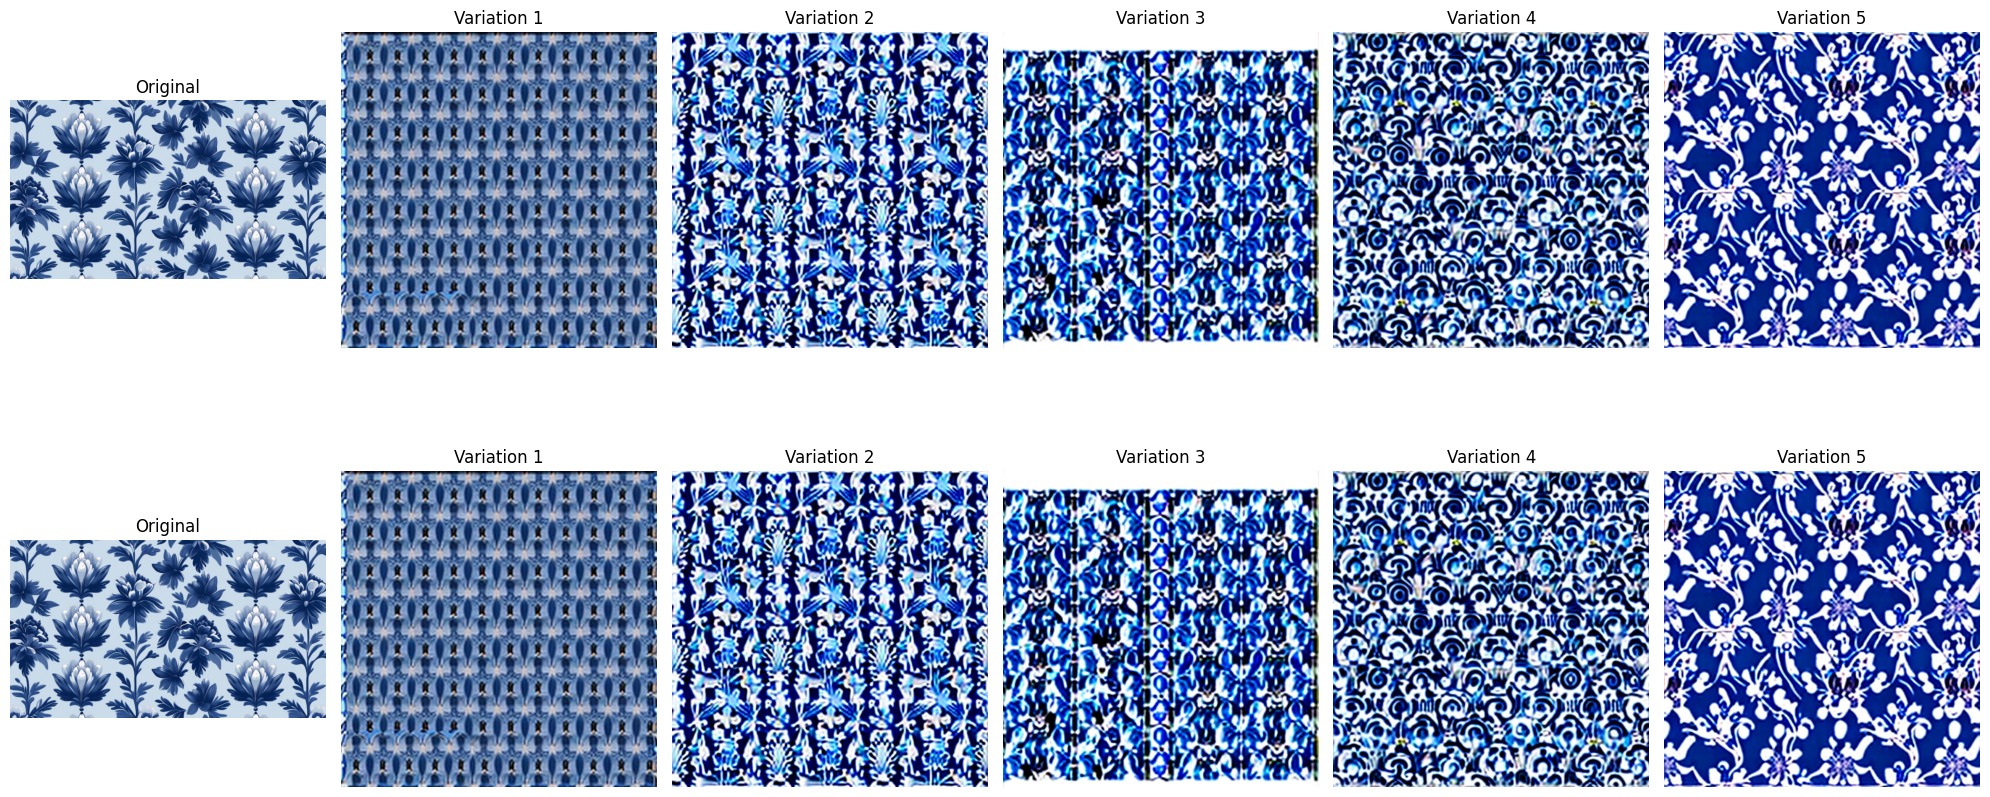

Training: 100%|██████████| 13866/13866 [1:15:31<00:00,  3.06batch/s, loss=0.182] 


Epoch 9/20 - Loss: 0.3042
Saved checkpoint to /kaggle/working/trained_models/checkpoint_9


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
finetuner.train(
    test_images=test_image_paths,  # Required parameter
    resume=True,                   
    start_epoch=8 
)